In [17]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize

### Simulation Data

In [18]:
# import data
t1, y1 = np.loadtxt("data/supersat.csv", delimiter=",", skiprows=1, unpack=True)
t2, y2 = np.loadtxt("data/mu1mu0.csv", delimiter=",", skiprows=1, unpack=True)
t3, y3 = np.loadtxt("data/mu2mu0.csv", delimiter=",", skiprows=1, unpack=True)
t4, y4 = np.loadtxt("data/mu3mu0.csv", delimiter=",", skiprows=1, unpack=True)
t5, y5 = np.loadtxt("data/B.csv", delimiter=",", skiprows=1, unpack=True)
t6, y6 = np.loadtxt("data/G.csv", delimiter=",", skiprows=1, unpack=True)

# Convert mu1/mu0, mu2/mu0, mu3/mu0 from cm, cm^2, cm^3 to m, m^2, m^3
y2 = y2 * 0.01          # cm to m
y3 = y3 * 0.0001        # cm^2 to m^2
y4 = y4 * 0.000001      # cm^3 to m^3

# interpolate data with linear interpolation
y1_interp = interp1d(t1, y1, kind='linear', bounds_error=False, fill_value="extrapolate")
y2_interp = interp1d(t2, y2, kind='linear', bounds_error=False, fill_value="extrapolate")
y3_interp = interp1d(t3, y3, kind='linear', bounds_error=False, fill_value="extrapolate")
y4_interp = interp1d(t4, y4, kind='linear', bounds_error=False, fill_value="extrapolate")
y5_interp = interp1d(t5, y5, kind='linear', bounds_error=False, fill_value="extrapolate")
y6_interp = interp1d(t6, y6, kind='linear', bounds_error=False, fill_value="extrapolate")

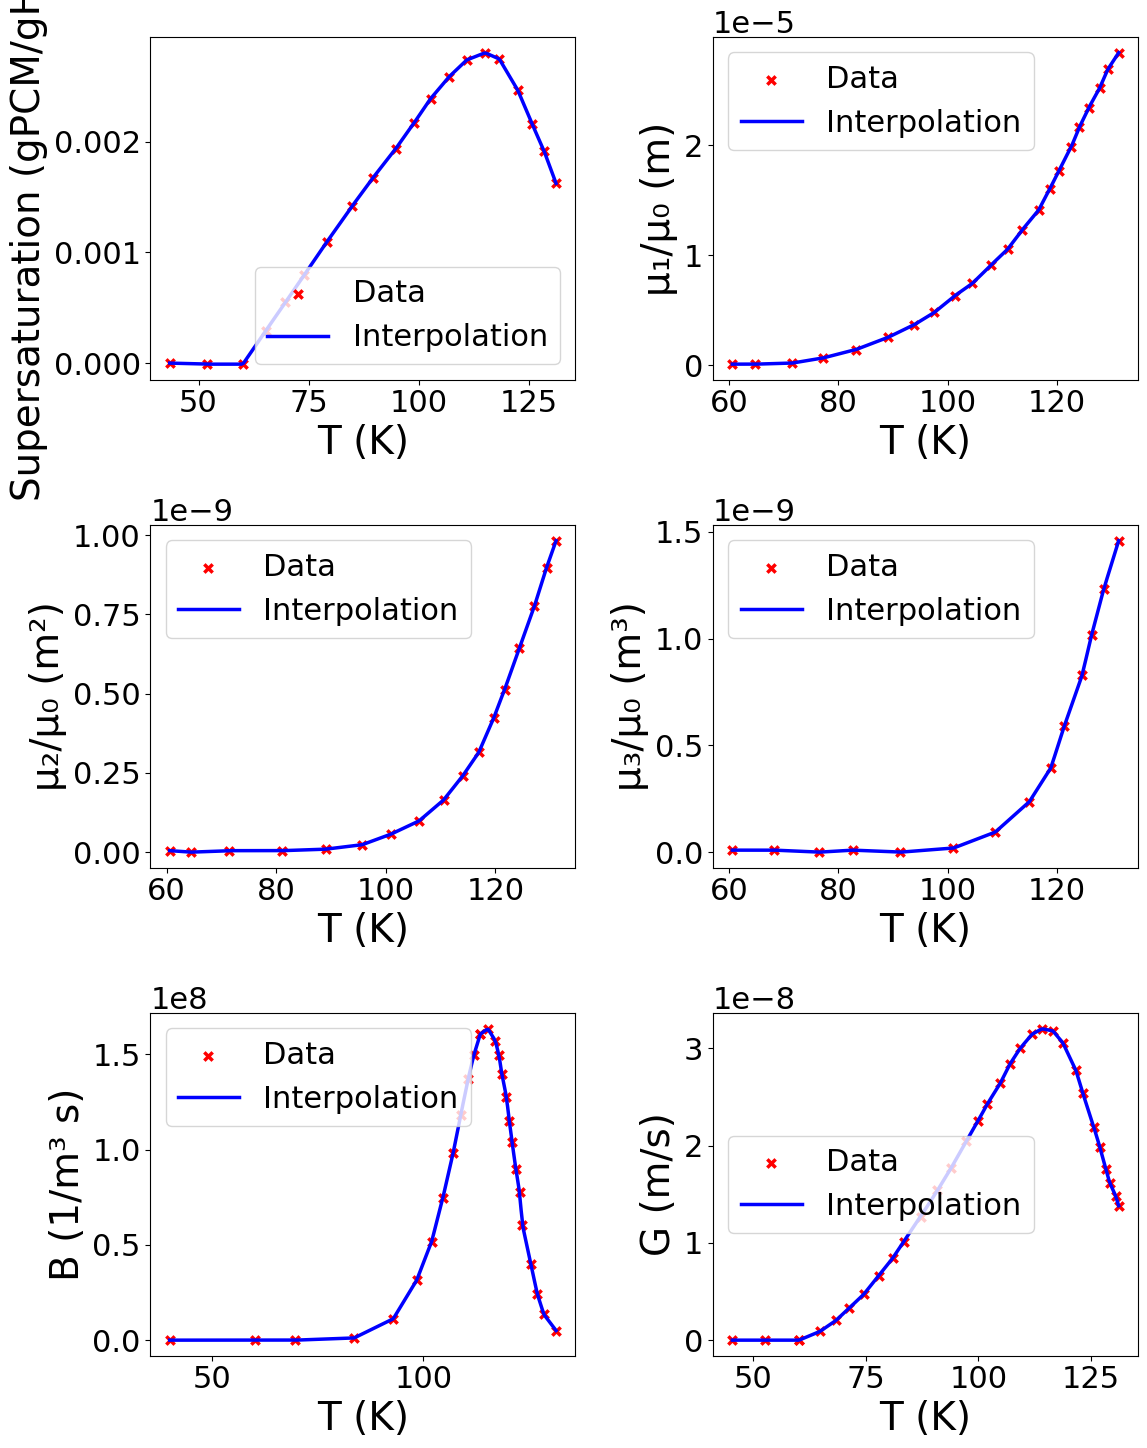

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# 1. supersat.csv
axs[0, 0].scatter(t1, y1, color="red", label="Data", marker='x')
x1_plot = np.linspace(np.min(t1), np.max(t1), 200)
axs[0, 0].plot(x1_plot, y1_interp(x1_plot), color="blue", label="Interpolation")
axs[0, 0].set_xlabel("T (K)")
axs[0, 0].set_ylabel("Supersaturation (gPCM/gH2O)")
axs[0, 0].legend()

# 2. mu1mu0.csv
axs[0, 1].scatter(t2, y2, color="red", marker='x', label="Data")
x2_plot = np.linspace(np.min(t2), np.max(t2), 200)
axs[0, 1].plot(x2_plot, y2_interp(x2_plot), color="blue", label="Interpolation")
axs[0, 1].set_xlabel("T (K)")
axs[0, 1].set_ylabel("μ₁/μ₀ (m)")
axs[0, 1].legend()

# 3. mu2mu0.csv
axs[1, 0].scatter(t3, y3, color="red", marker='x', label="Data")
x3_plot = np.linspace(np.min(t3), np.max(t3), 200)
axs[1, 0].plot(x3_plot, y3_interp(x3_plot), color="blue", label="Interpolation")
axs[1, 0].set_xlabel("T (K)")
axs[1, 0].set_ylabel("μ₂/μ₀ (m²)")
axs[1, 0].legend()

# 4. mu3mu0.csv
axs[1, 1].scatter(t4, y4, color="red", marker='x', label="Data")
x4_plot = np.linspace(np.min(t4), np.max(t4), 200)
axs[1, 1].plot(x4_plot, y4_interp(x4_plot), color="blue", label="Interpolation")
axs[1, 1].set_xlabel("T (K)")
axs[1, 1].set_ylabel("μ₃/μ₀ (m³)")
axs[1, 1].legend()

# 5. B.csv
axs[2, 0].scatter(t5, y5, color="red", marker='x', label="Data")
x5_plot = np.linspace(np.min(t5), np.max(t5), 200)
axs[2, 0].plot(x5_plot, y5_interp(x5_plot), color="blue", label="Interpolation")
axs[2, 0].set_xlabel("T (K)")
axs[2, 0].set_ylabel("B (1/m³ s)")
axs[2, 0].legend()

# 6. G.csv
axs[2, 1].scatter(t6, y6, color="red", marker='x', label="Data")
x6_plot = np.linspace(np.min(t6), np.max(t6), 200)
axs[2, 1].plot(x6_plot, y6_interp(x6_plot), color="blue", label="Interpolation")
axs[2, 1].set_xlabel("T (K)")
axs[2, 1].set_ylabel("G (m/s)")
axs[2, 1].legend()

plt.tight_layout()
plt.show()

### Saturation Curve

Paracetamole/Water System

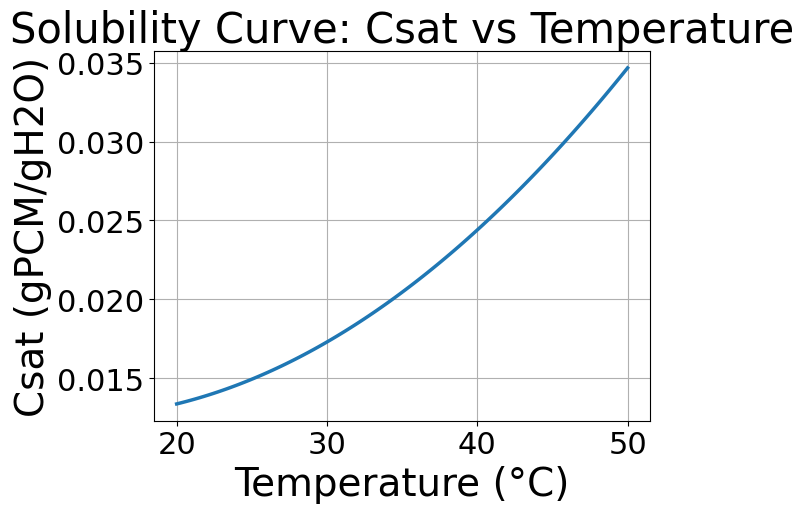

In [20]:
sat_const = 1.5846e-5, -9.0567e-03, 1.3066   # Solubility: second order polynomial, gPCM/gH2O, K, K^

def Csat(T, const=sat_const):
    """The solubility of paracetamol in water (g PCM/g water) as a function of temperature (in K)"""
    A, B, C = const
    return A*T**2 + B*T + C    # kg/m^3


T_plot = np.linspace(20+273.15, 50+273.15, 100)
Csat_vals = [Csat(T) for T in T_plot]

plt.figure()
plt.plot(T_plot - 273.15, Csat_vals)
plt.xlabel("Temperature (°C)")
plt.ylabel("Csat (gPCM/gH2O)")
plt.title("Solubility Curve: Csat vs Temperature")
plt.grid()
plt.show()

## Figs

### Import Final Data

In [21]:
# Load results
loaded = np.load('results/y_guess.npz')
y1_guess = loaded['y1']
y2_guess = loaded['y2']
y3_guess = loaded['y3']
y4_guess = loaded['y4']
y5_guess = loaded['y5']
y6_guess = loaded['y6']
t_array = loaded['t_array']

loaded = np.load('results/y_method1.npz')
y1_method1 = loaded['y1']
y2_method1 = loaded['y2']
y3_method1 = loaded['y3']
y4_method1 = loaded['y4']
y5_method1 = loaded['y5']
y6_method1 = loaded['y6']
t_array_method1 = loaded['t_array']

loaded = np.load('results/y_method2.npz')
y1_method2 = loaded['y1']
y2_method2 = loaded['y2']
y3_method2 = loaded['y3']
y4_method2 = loaded['y4']
y5_method2 = loaded['y5']
y6_method2 = loaded['y6']
t_array_method2 = loaded['t_array']

loaded = np.load('results/y_final.npz')
y1_final = loaded['y1']
y2_final = loaded['y2']
y3_final = loaded['y3']
y4_final = loaded['y4']
y5_final = loaded['y5']
y6_final = loaded['y6']
t_array_final = loaded['t_array']

loaded = np.load('results/sol_final.npz')
t_final = loaded['t_array']
mu0_final = loaded['mu0']
mu1_final = loaded['mu1']
mu2_final = loaded['mu2']
mu3_final = loaded['mu3']
C_final = loaded['C']
T_final = loaded['T']

### Curve Fit Summary

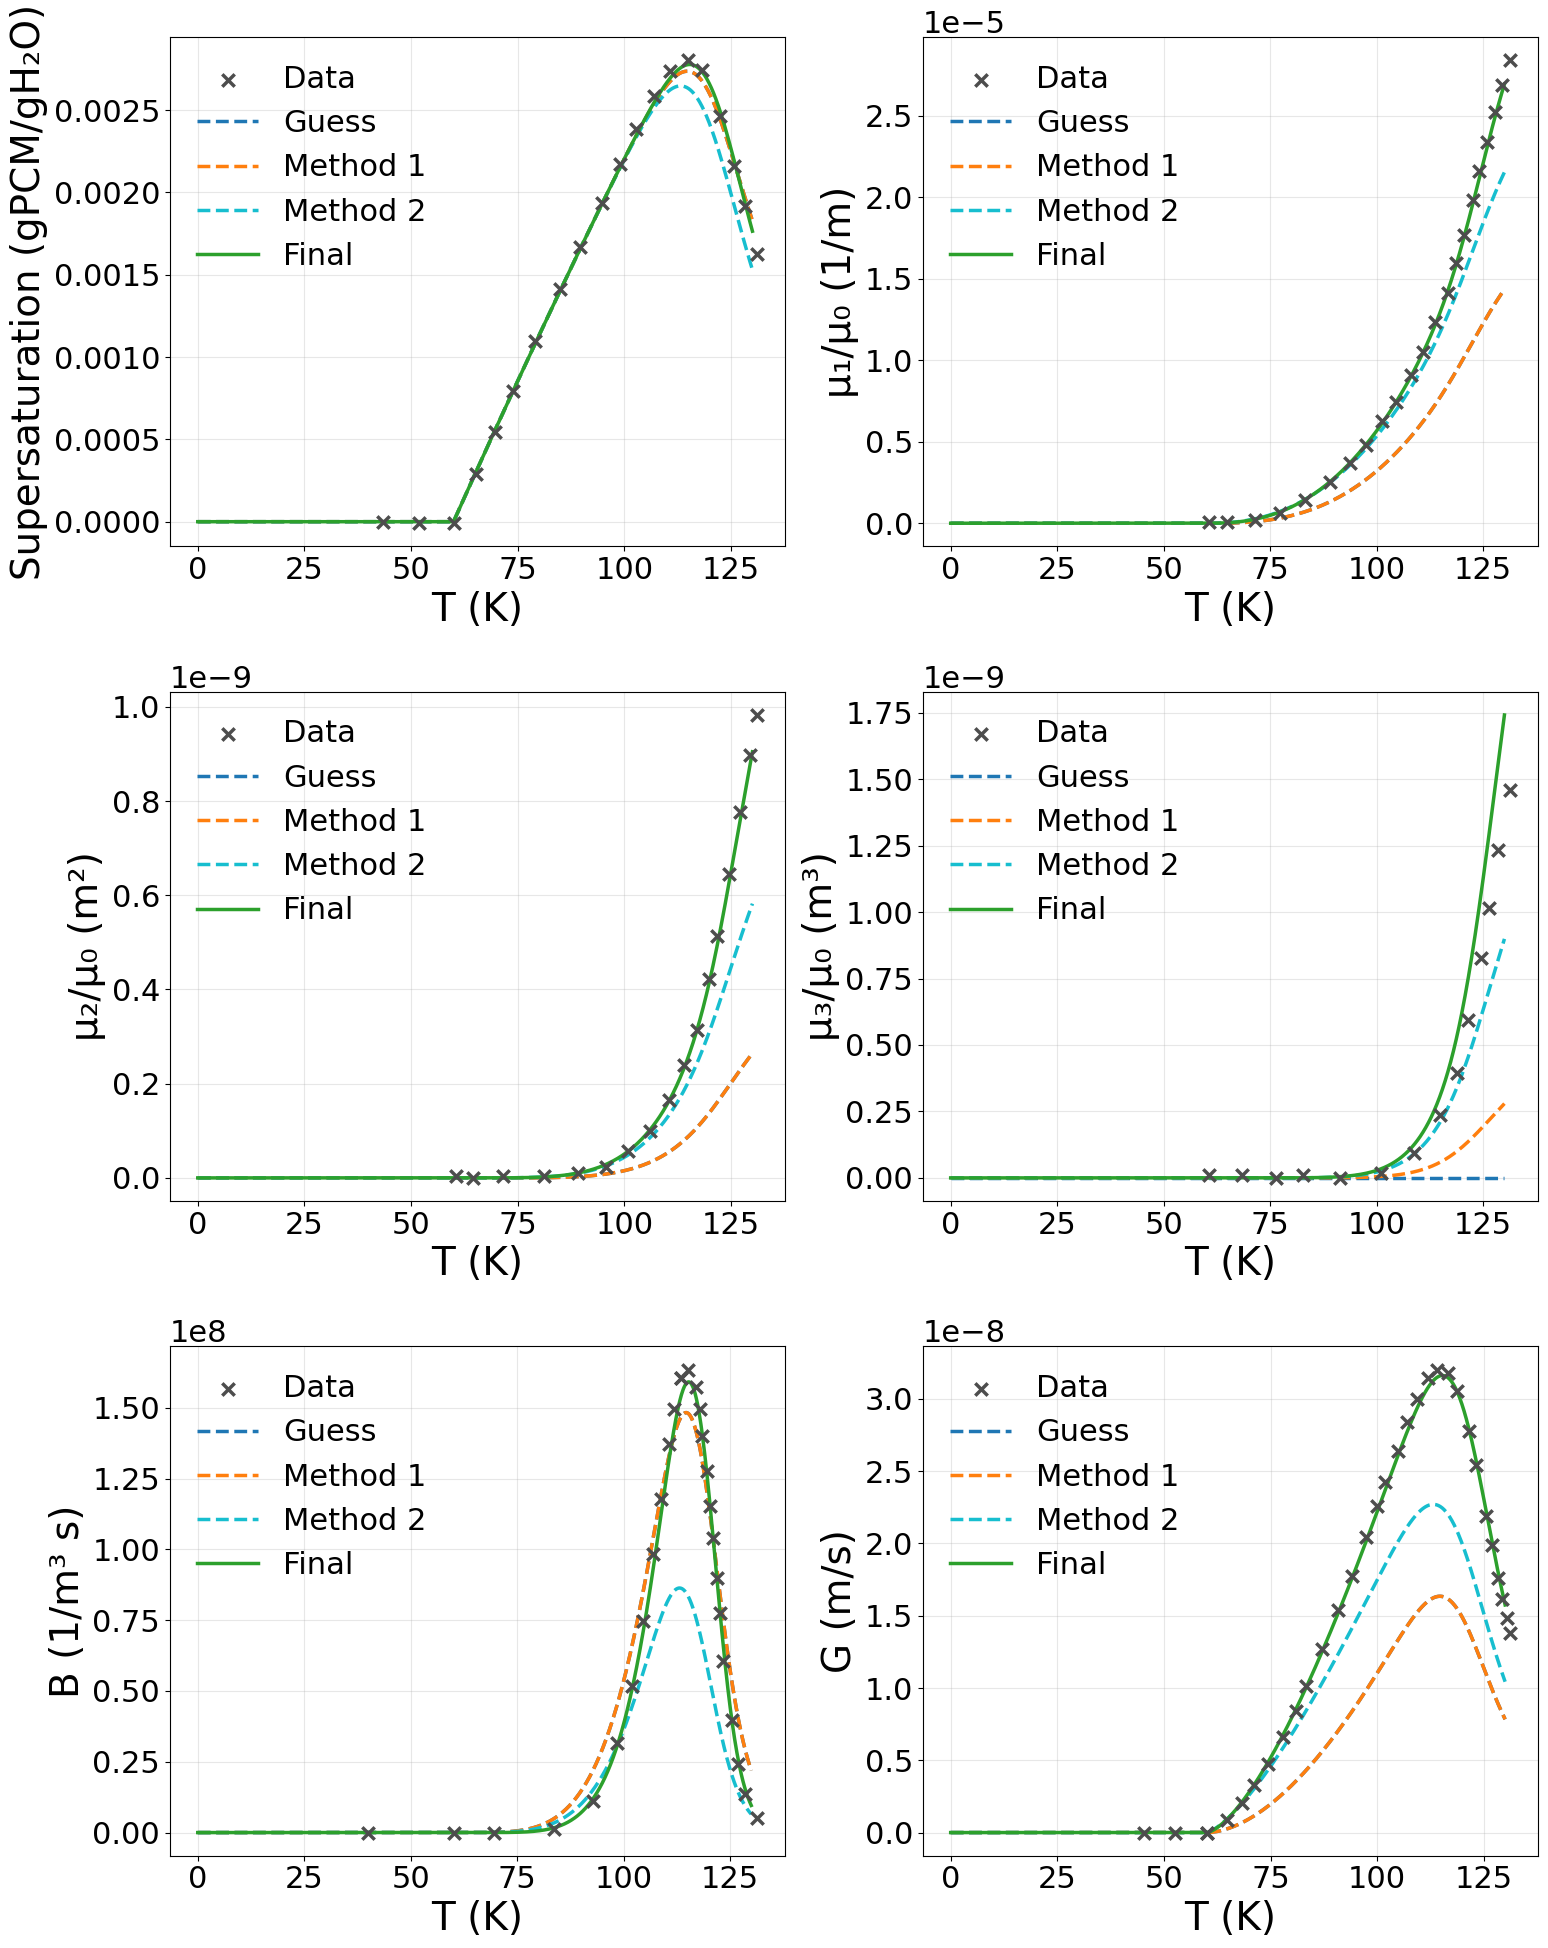

In [22]:
import matplotlib.pyplot as plt

# --- Poster-friendly font + line settings ---
plt.rcParams.update({
    "font.size": 24,          # base font
    "axes.titlesize": 30,
    "axes.labelsize": 28,     # axis labels
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 22,
    "lines.linewidth": 2.5,
})

# Time scaling
t_array_scaled = t_array/60
t_array_method1_scaled = t_array_method1/60
t_array_method2_scaled = t_array_method2/60
t_array_final_scaled = t_array_final/60

# --- Large poster-sized figure ---
fig, axs = plt.subplots(3, 2, figsize=(16, 20))

data_color    = "#4D4D4D"
guess_color   = "#1f77b4"
method1_color = "#ff7f0e"
method2_color = "#17becf"
final_color   = "#2ca02c"

scatter_kwargs = dict(marker="x", s=80, zorder=5)

# Helper to add legend without frame
def add_legend(ax):
    ax.legend(frameon=False)

# 1. μ₀ vs T
axs[0, 0].scatter(t1, y1, color=data_color, label="Data", **scatter_kwargs)
axs[0, 0].plot(t_array_scaled, y1_guess,      color=guess_color,   linestyle="--", label="Guess")
axs[0, 0].plot(t_array_method1_scaled, y1_method1, color=method1_color, linestyle="--", label="Method 1")
axs[0, 0].plot(t_array_method2_scaled, y1_method2, color=method2_color, linestyle="--", label="Method 2")
axs[0, 0].plot(t_array_final_scaled, y1_final, color=final_color, linestyle="-", label="Final")
axs[0, 0].set_xlabel("T (K)")
axs[0, 0].set_ylabel("Supersaturation (gPCM/gH₂O)")
add_legend(axs[0, 0])

# 2. μ₁/μ₀
axs[0, 1].scatter(t2, y2, color=data_color, label="Data", **scatter_kwargs)
axs[0, 1].plot(t_array_scaled, y2_guess,      color=guess_color,   linestyle="--", label="Guess")
axs[0, 1].plot(t_array_method1_scaled, y2_method1, color=method1_color, linestyle="--", label="Method 1")
axs[0, 1].plot(t_array_method2_scaled, y2_method2, color=method2_color, linestyle="--", label="Method 2")
axs[0, 1].plot(t_array_final_scaled, y2_final, color=final_color, linestyle="-", label="Final")
axs[0, 1].set_xlabel("T (K)")
axs[0, 1].set_ylabel("μ₁/μ₀ (1/m)")
add_legend(axs[0, 1])

# 3. μ₂/μ₀
axs[1, 0].scatter(t3, y3, color=data_color, label="Data", **scatter_kwargs)
axs[1, 0].plot(t_array_scaled, y3_guess,      color=guess_color,   linestyle="--", label="Guess")
axs[1, 0].plot(t_array_method1_scaled, y3_method1, color=method1_color, linestyle="--", label="Method 1")
axs[1, 0].plot(t_array_method2_scaled, y3_method2, color=method2_color, linestyle="--", label="Method 2")
axs[1, 0].plot(t_array_final_scaled, y3_final, color=final_color, linestyle="-", label="Final")
axs[1, 0].set_xlabel("T (K)")
axs[1, 0].set_ylabel("μ₂/μ₀ (m²)")
add_legend(axs[1, 0])

# 4. μ₃/μ₀
axs[1, 1].scatter(t4, y4, color=data_color, label="Data", **scatter_kwargs)
axs[1, 1].plot(t_array_scaled, y4_guess,      color=guess_color,   linestyle="--", label="Guess")
axs[1, 1].plot(t_array_method1_scaled, y4_method1*5e4, color=method1_color, linestyle="--", label="Method 1")
axs[1, 1].plot(t_array_method2_scaled, y4_method2*5e4, color=method2_color, linestyle="--", label="Method 2")
axs[1, 1].plot(t_array_final_scaled, y4_final*5e4, color=final_color, linestyle="-", label="Final")
axs[1, 1].set_xlabel("T (K)")
axs[1, 1].set_ylabel("μ₃/μ₀ (m³)")
add_legend(axs[1, 1])

# 5. B
axs[2, 0].scatter(t5, y5, color=data_color, label="Data", **scatter_kwargs)
axs[2, 0].plot(t_array_scaled, y5_guess, color=guess_color, linestyle="--", label="Guess")
axs[2, 0].plot(t_array_method1_scaled, y5_method1, color=method1_color, linestyle="--", label="Method 1")
axs[2, 0].plot(t_array_method2_scaled, y5_method2, color=method2_color, linestyle="--", label="Method 2")
axs[2, 0].plot(t_array_final_scaled, y5_final, color=final_color, linestyle="-", label="Final")
axs[2, 0].set_xlabel("T (K)")
axs[2, 0].set_ylabel("B (1/m³ s)")
add_legend(axs[2, 0])

# 6. G
axs[2, 1].scatter(t6, y6, color=data_color, label="Data", **scatter_kwargs)
axs[2, 1].plot(t_array_scaled, y6_guess, color=guess_color, linestyle="--", label="Guess")
axs[2, 1].plot(t_array_method1_scaled, y6_method1, color=method1_color, linestyle="--", label="Method 1")
axs[2, 1].plot(t_array_method2_scaled, y6_method2, color=method2_color, linestyle="--", label="Method 2")
axs[2, 1].plot(t_array_final_scaled, y6_final, color=final_color, linestyle="-", label="Final")
axs[2, 1].set_xlabel("T (K)")
axs[2, 1].set_ylabel("G (m/s)")
add_legend(axs[2, 1])

# Optional light grids
for ax in axs.ravel():
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figs/curve_fit_summary.png", dpi=300, bbox_inches="tight")
plt.show()


### Supersaturation Figure

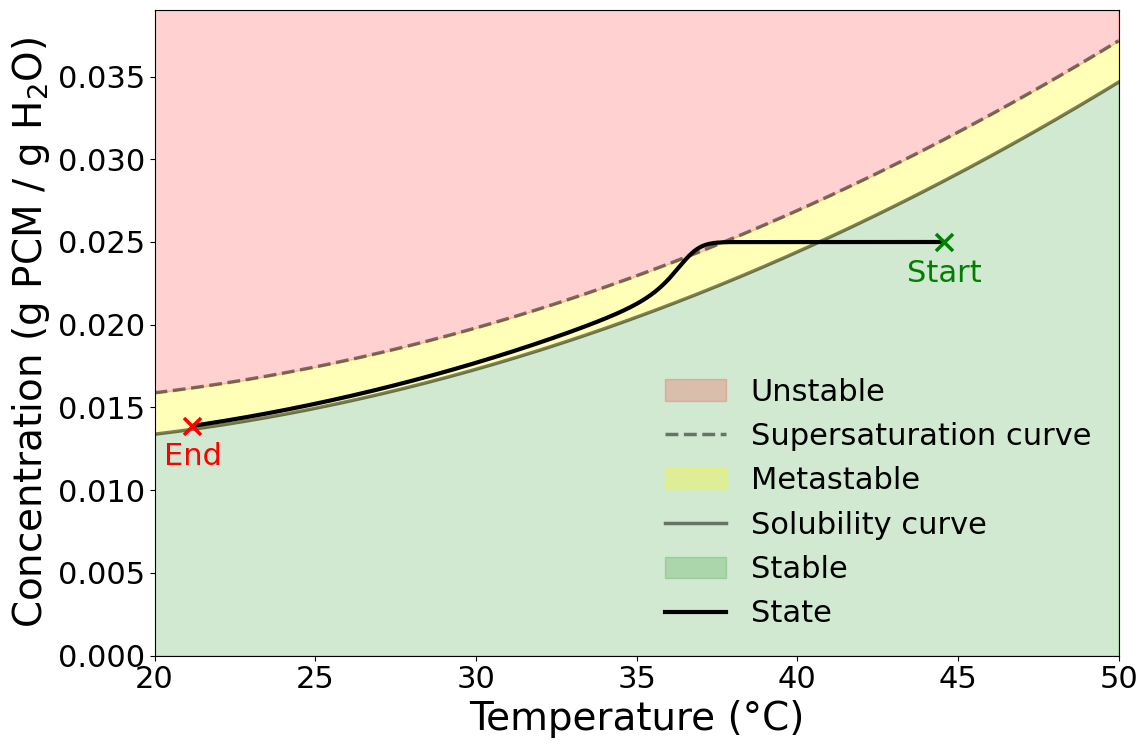

In [24]:
sat_const = 1.5846e-5, -9.0567e-03, 1.3066   # Solubility polynomial: g PCM / g H2O

def Csat(T, const=sat_const):
    """Solubility of paracetamol in water (g PCM / g H2O) as a function of temperature (K)."""
    A, B, C = const
    return A*T**2 + B*T + C

# Temperature range (K)
T_plot = np.linspace(20+273.15, 50+273.15, 300)
T_C = T_plot - 273.15

Csat_vals = Csat(T_plot)
sup_vals  = Csat_vals + 0.0025   # Offset supersaturation curve

# --------------------------
# Build clean boundary limits
# --------------------------
x_min = T_C.min()
x_max = T_C.max()

y_min = 0
y_max = sup_vals.max() * 1.05  # Slight padding at top

# Larger figure to match large fonts on a 48x36 poster
plt.figure(figsize=(12, 8))

# --------------------------
# Shade regions (low zorder so they stay in the back)
# --------------------------
# Stable region (below solubility)
plt.fill_between(
    T_C, y_min, Csat_vals,
    color="green", alpha=0.18, label="Stable", zorder=1
)

# Metastable region
plt.fill_between(
    T_C, Csat_vals, sup_vals,
    color="yellow", alpha=0.28, label="Metastable", zorder=1
)

# Unstable region
plt.fill_between(
    T_C, sup_vals, y_max,
    color="red", alpha=0.18, label="Unstable", zorder=1
)

# --------------------------
# Draw curves (slightly above fills)
# --------------------------
plt.plot(
    T_C, Csat_vals,
    color="black", linewidth=2.5, alpha=0.5,    # Increased opacity (was 0.8)
    label="Solubility curve", zorder=2
)
plt.plot(
    T_C, sup_vals,
    color="black", linestyle="--", linewidth=2.5, alpha=0.5,   # Increased opacity (was 0.8)
    label="Supersaturation curve", zorder=2
)

# Optional final state curve (no markers)
plt.plot(
    T_final - 273.15, C_final,
    color="black", linewidth=3,
    label="State", zorder=3
)

# --------------------------
# Mark starting and last state (highest zorder)
# --------------------------
marker_size = 150  # larger markers for poster

# Green 'x' for starting state
T_initial = T_final[0]
C_initial = C_final[0]
plt.scatter(
    T_initial - 273.15, C_initial,
    color='green', marker='x', s=marker_size, zorder=5
)
plt.text(
    T_initial - 273.15, C_initial - 0.001,
    "Start", color='green', fontsize=22,
    ha='center', va='top', zorder=6
)

# Red 'x' for final state
T_last = T_final[-1]
C_last = C_final[-1]
plt.scatter(
    T_last - 273.15, C_last,
    color='red', marker='x', s=marker_size, zorder=5
)
plt.text(
    T_last - 273.15, C_last - 0.001,
    "End", color='red', fontsize=22,
    ha='center', va='top', zorder=6
)

# --------------------------
# Style cleanup
# --------------------------
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Temperature (°C)")
plt.ylabel("Concentration (g PCM / g H$_2$O)")

plt.grid(False)

# --------------------------
# Legend: custom order
# Unstable, Supersaturation curve, Metastable,
# Solubility curve, Stable, State
# --------------------------
handles, labels = plt.gca().get_legend_handles_labels()

order = [
    labels.index("Unstable"),
    labels.index("Supersaturation curve"),
    labels.index("Metastable"),
    labels.index("Solubility curve"),
    labels.index("Stable"),
    labels.index("State"),
]

plt.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    frameon=False
)

plt.tight_layout()
plt.savefig("figs/supersaturation_fig.png", dpi=300, bbox_inches="tight")
plt.show()
